In [19]:
library(cluster)
library(dplyr)
library(ggplot2)
library(readr)
library(Rtsne)
library(ISLR) # for college dataset

In [20]:
college_clean <- College %>%
  mutate(name = row.names(.),
         accept_rate = Accept/Apps,
         isElite = cut(Top10perc,
                       breaks = c(0, 50, 100),
                       labels = c("Not Elite", "Elite"),
                       include.lowest = TRUE)) %>%
  mutate(isElite = factor(isElite)) %>%
  select(name, accept_rate, Outstate, Enroll,
         Grad.Rate, Private, isElite)

glimpse(college_clean)



# Remove college name before clustering



Observations: 777
Variables: 7
$ name        <chr> "Abilene Christian University", "Adelphi University", "Ad…
$ accept_rate <dbl> 0.7421687, 0.8801464, 0.7682073, 0.8369305, 0.7564767, 0.…
$ Outstate    <dbl> 7440, 12280, 11250, 12960, 7560, 13500, 13290, 13868, 155…
$ Enroll      <dbl> 721, 512, 336, 137, 55, 158, 103, 489, 227, 172, 472, 484…
$ Grad.Rate   <dbl> 60, 56, 54, 59, 15, 55, 63, 73, 80, 52, 73, 76, 74, 68, 5…
$ Private     <fct> Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Ye…
$ isElite     <fct> Not Elite, Not Elite, Not Elite, Elite, Not Elite, Not El…


In [21]:
gower_dist <- daisy(college_clean[, -1],
                    metric = "gower",
                    type = list(logratio = 3))


summary(gower_dist)



gower_mat <- as.matrix(gower_dist)



301476 dissimilarities, summarized :
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00186 0.10344 0.23587 0.23145 0.32714 0.77735 
Metric :  mixed ;  Types = I, I, I, I, N, N 
Number of objects : 777

In [22]:
# Output most similar pair

college_clean[
  which(gower_mat == min(gower_mat[gower_mat != min(gower_mat)]),
        arr.ind = TRUE)[1, ], ]



# Output most dissimilar pair

college_clean[
  which(gower_mat == max(gower_mat[gower_mat != max(gower_mat)]),
        arr.ind = TRUE)[1, ], ]






,name,accept_rate,Outstate,Enroll,Grad.Rate,Private,isElite
682,University of St. Thomas MN,0.8784638,11712,828,89,Yes,Not Elite
284,John Carroll University,0.8711276,11700,820,89,Yes,Not Elite


,name,accept_rate,Outstate,Enroll,Grad.Rate,Private,isElite
673,University of Sci. and Arts of Oklahoma,0.9824561,3687,208,43,No,Not Elite
251,Harvard University,0.1561486,18485,1606,100,Yes,Elite


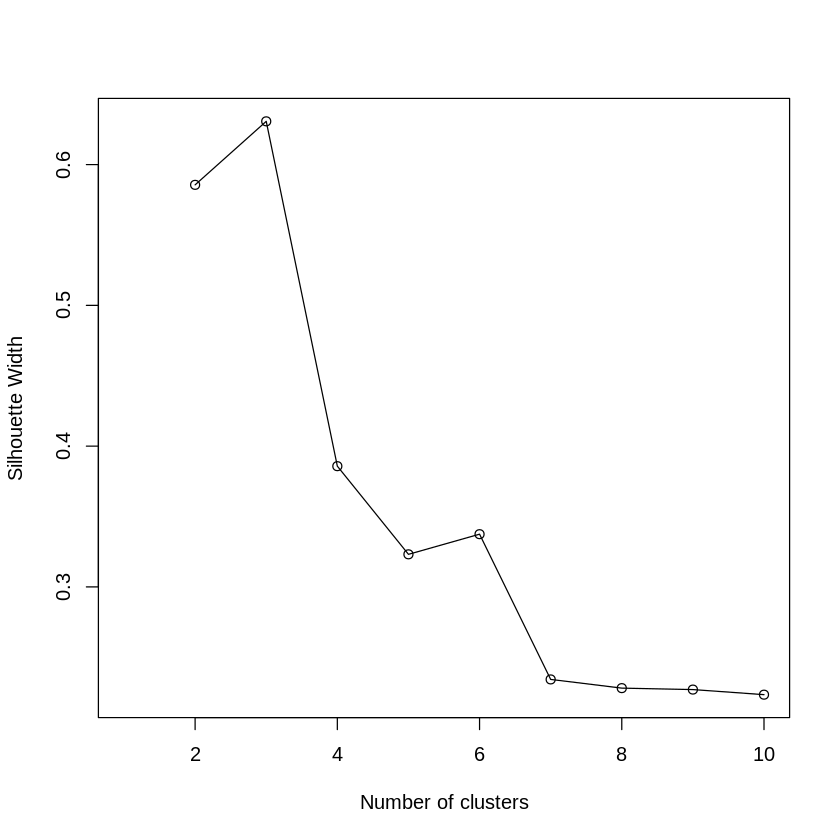

In [23]:
# Calculate silhouette width for many k using PAM

sil_width <- c(NA)

for(i in 2:10){
  
  pam_fit <- pam(gower_dist,
                 diss = TRUE,
                 k = i)
  
  sil_width[i] <- pam_fit$silinfo$avg.width
  
}

# Plot sihouette width (higher is better)

plot(1:10, sil_width,
     xlab = "Number of clusters",
     ylab = "Silhouette Width")
lines(1:10, sil_width)





In [24]:
pam_fit <- pam(gower_dist, diss = TRUE, k = 3)

pam_results <- college_clean %>%
  dplyr::select(-name) %>%
  mutate(cluster = pam_fit$clustering) %>%
  group_by(cluster) %>%
  do(the_summary = summary(.))

pam_results$the_summary



college_clean[pam_fit$medoids, ]

[[1]]
  accept_rate        Outstate         Enroll         Grad.Rate      Private  
 Min.   :0.3283   Min.   : 2340   Min.   :  35.0   Min.   : 15.00   No :  0  
 1st Qu.:0.7225   1st Qu.: 8842   1st Qu.: 194.8   1st Qu.: 56.00   Yes:500  
 Median :0.8004   Median :10905   Median : 308.0   Median : 67.50            
 Mean   :0.7820   Mean   :11200   Mean   : 418.6   Mean   : 66.97            
 3rd Qu.:0.8581   3rd Qu.:13240   3rd Qu.: 484.8   3rd Qu.: 78.25            
 Max.   :1.0000   Max.   :21700   Max.   :4615.0   Max.   :118.00            
      isElite       cluster 
 Not Elite:500   Min.   :1  
 Elite    :  0   1st Qu.:1  
                 Median :1  
                 Mean   :1  
                 3rd Qu.:1  
                 Max.   :1  

[[2]]
  accept_rate        Outstate         Enroll         Grad.Rate      Private 
 Min.   :0.1545   Min.   : 5224   Min.   : 137.0   Min.   : 54.00   No : 4  
 1st Qu.:0.4135   1st Qu.:13850   1st Qu.: 391.0   1st Qu.: 77.00   Yes:65  
 Median

,name,accept_rate,Outstate,Enroll,Grad.Rate,Private,isElite
492,Saint Francis College,0.7877629,10880,284,69,Yes,Not Elite
38,Barnard College,0.5616987,17926,531,91,Yes,Elite
234,Grand Valley State University,0.7525653,6108,1561,57,No,Not Elite


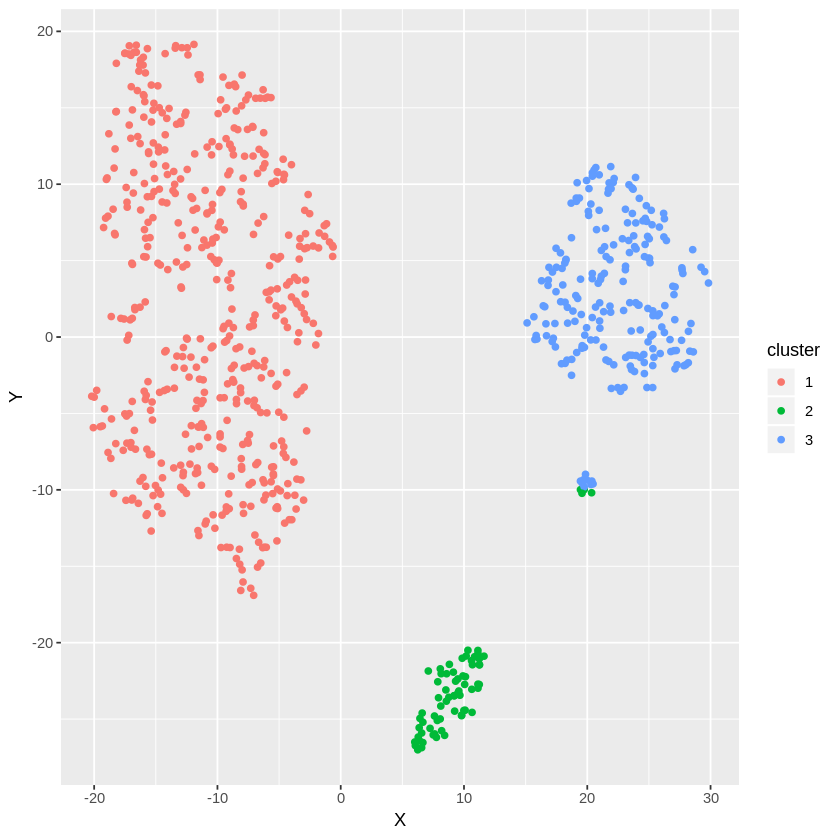

In [25]:
#Visualization in a lower dimensional space

tsne_obj <- Rtsne(gower_dist, is_distance = TRUE)

tsne_data <- tsne_obj$Y %>%
  data.frame() %>%
  setNames(c("X", "Y")) %>%
  mutate(cluster = factor(pam_fit$clustering),
         name = college_clean$name)

ggplot(aes(x = X, y = Y), data = tsne_data) +
  geom_point(aes(color = cluster))

